In [ ]:
# default_exp pseudodata

# pseudodata

Classes for generating pseudodata used in INFERNO paper

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# export
from fastcore.all import store_attr
from typing import Callable, Tuple, Union, List
import numpy as np
import pandas as pd

In [ ]:
# export
class PseudoData():
    r'''Generic class for constructing pseudodata via sampling of random functions'''
    def __init__(self, func:Callable[[int],np.ndarray], targ:Union[float,int]): store_attr()
    def __getitem__(self, i:int) -> Tuple[np.ndarray,np.ndarray]: self.sample(1)
    def sample(self, n:int) -> Tuple[np.ndarray,np.ndarray,None]: return self.func(n).astype('float32'),self.targ*np.ones((n,1)).astype('float32'),None
    def __call__(self, n:int) -> Tuple[np.ndarray,np.ndarray,None]: return self.sample(n)
    def get_df(self, n:int) -> pd.DataFrame:
        d = self.sample(n)
        if d[2] is None: d = d[:2]
        df = pd.DataFrame(np.hstack(d))
        df.rename(columns={df.columns[-1]:'gen_target'}, inplace=True)
        return df

In [ ]:
d = PseudoData(lambda x: np.random.normal(0,1,(x,3)), 0)
df = d.get_df(10)
assert df.values.shape == (10,4)
df.head()

,0,1,2,gen_target
0,-0.059475,1.210967,-0.422888,0.0
1,-0.414044,1.268999,-0.580749,0.0
2,-0.697192,-0.487871,-1.681089,0.0
3,2.124146,1.264359,1.976336,0.0
4,2.111995,0.868064,2.019226,0.0


## INFERNO paper

In [ ]:
# export
class _PaperData():
    r'''Callable class generating pseudodata from Inferno paper'''
    def __init__(self, mu:List[float], conv:List[List[float]], r:float, l:float):
        store_attr(but=['mu', 'r'])
        self.r = np.array([r,0])
        self.mu = np.array(mu)
        
    def sample(self, n:int) -> np.ndarray:
        return np.hstack((np.random.multivariate_normal(self.mu+self.r, self.conv, n),
                          np.random.exponential(1/self.l, size=n)[:,None]))
        
    def __call__(self, n:int) -> np.ndarray: return self.sample(n)

Callable class generating signal data. NB, paper states `mu=[1,1]`, but plots and code indicate `mu=[0,0]`

In [ ]:
# export
paper_sig = _PaperData(mu=[0,0], conv=[[1,0],[0,1]], r=0, l=2)

In [ ]:
s0 = paper_sig(2)
print(s0)
assert s0.shape == (2,3)

[[-1.44562602 -0.1492472   0.16018372]
 [-0.45275426 -0.71965287  0.08061889]]


In [ ]:
paper_sig1 = _PaperData([0,0], [[1,0],[0,1]], 0, 2)
paper_sig1.r[0] += 1000
paper_sig1.r

array([1000,    0])

In [ ]:
s1 = paper_sig1(2)
print(s1)
assert s1[0,0] > s0[0,0]

[[9.99702050e+02 1.78013375e+00 1.09574848e-01]
 [9.98718875e+02 1.58931519e+00 7.29373500e-01]]


Callable class generating background data with nuisances at nominal values

In [ ]:
# export
paper_bkg = _PaperData(mu=[2,0], conv=[[5,0],[0,9]], r=0, l=3)

### Check

In [ ]:
n=1000
df = PseudoData(paper_sig, 1).get_df(n).append(PseudoData(paper_bkg, 0).get_df(n), ignore_index=True)
df

,0,1,2,gen_target
0,2.544023,0.442834,0.139470,1.0
1,-0.775732,0.719415,0.617672,1.0
2,-0.875915,-0.727330,0.406364,1.0
3,1.688095,0.688291,0.610886,1.0
4,0.528951,-0.639645,0.112357,1.0
...,...,...,...,...
1995,1.793329,1.821786,0.007961,0.0
1996,-1.923585,-1.982377,0.112923,0.0
1997,4.552509,-1.837093,0.467405,0.0
1998,-0.558329,0.875070,0.550241,0.0


Reproduces paper plots

/home/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


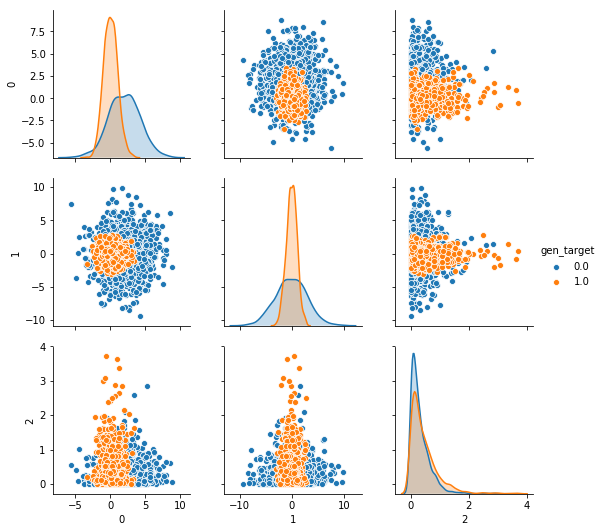

In [ ]:
import seaborn as sns
sns.pairplot(df, hue='gen_target', vars=[f for f in df.columns if f != 'gen_target'])